# Linear regression

We sort the data as previously done.

In [2]:
set.seed(1)
data <- read.csv(file.path("..","..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

In [3]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

As the number of predictors is big (and far greater than the number of observations), we can predict that multiple linear regression model without any restriction will give really bad predictions, but we will try it to have a starting point.

We create train set and validation sets in both matrix and data.frame formats.

In [4]:
idx <- sample(nrow(data), 4*nrow(data)/5)
#matrix
train.x <- data[idx,]
train.x$PL <- NULL
train.x <- as.matrix(train.x)
train.y <- data$PL[idx]

test.x <- data[-idx,]
test.x$PL <- NULL
test.x <- as.matrix(test.x)
test.y <- data$PL[-idx]

#data.frame
train.set = data[idx,]
test.set = data[-idx,]

dim(train.x)
dim(test.x)
length(train.y)
length(test.y)

dim(train.set)
dim(test.set)

[1]  566 3028

[1]  142 3028

[1] 566

[1] 142

[1]  566 3029

[1]  142 3029

In [5]:
lin.fit <- lm(PL ~ ., train.set)

In [6]:
y.pred <- predict(lin.fit, test.set)
lm.MSE <- mean((y.pred - test.set$PL)^2)
paste('MSE = ',lm.MSE)
paste('adjusted $R^2$ low: ', summary(lin.fit)$adj.r.squared)

Warning message in predict.lm(lin.fit, test.set):
"prediction from a rank-deficient fit may be misleading"


[1] "MSE =  1884252.78024588"

[1] "adjusted $R^2$ low:  0.290215455279898"

In [7]:
min(y.pred)
max(y.pred)
min(test.set$PL)
max(test.set$PL)

[1] -8426.52

[1] 5187.024

[1] 0

[1] 96

As we could expect with so many predictors, the multiple linear regression (with all predictors) is terrible, with outliers going far outside the grade range.

# Lasso regularization (cross-validation)

We can try linear regression with lasso (L1/2) regularization to drop predictors that create such outliers.

Let's first look at the evolution of coefficients for different lambda values:

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-16




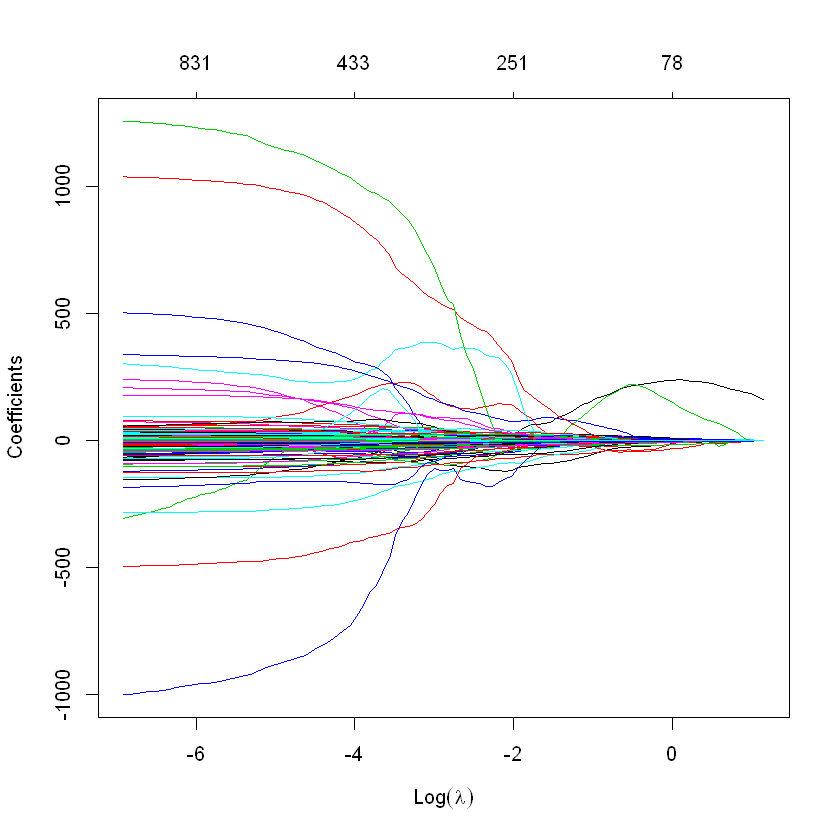

In [8]:
library(glmnet)
lasso1.mod <- glmnet(train.x, train.y, alpha = 1, lambda = 10^seq(0.5, -3, length = 100))
plot(lasso1.mod, "lambda", xlab = parse(text = "Log(lambda)"))

We can find the best lambda value by cross-validation:

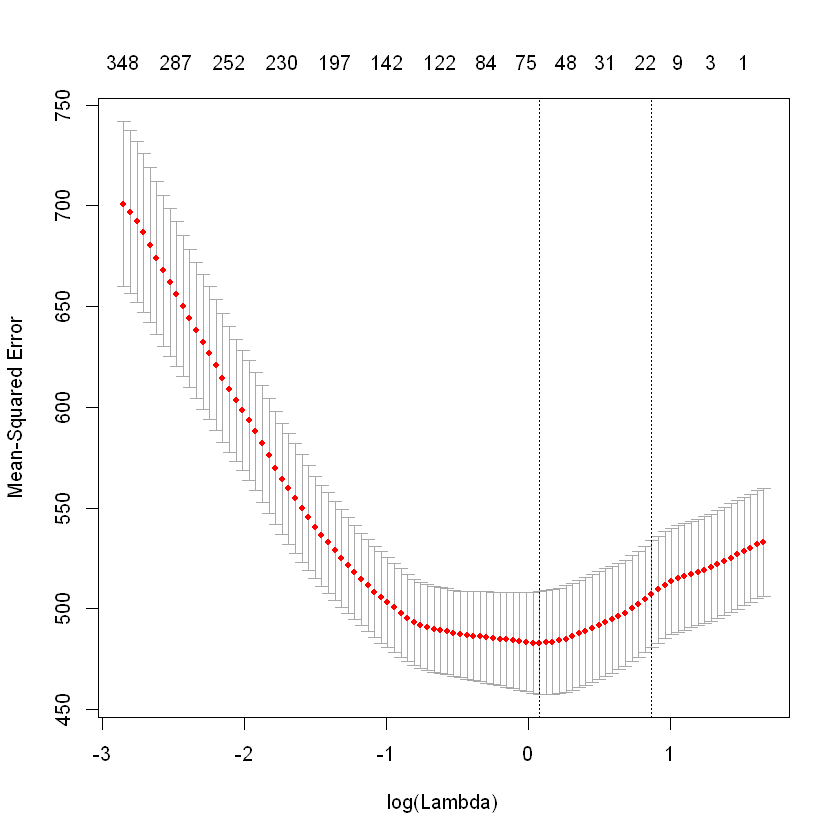

In [18]:
set.seed(1)
cv.lasso1 <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 10)
plot(cv.lasso1)

Now we find the best coefficients (around 50) for linear regression given by lasso (L1):

In [19]:
best.lasso1 <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso1$lambda.min)

In [20]:
paste('Number of non-zero predictors :', best.lasso1$df)

y.pred <- predict(best.lasso1, test.x)
lasso1.MSE <- mean((y.pred - test.y)^2)
paste('MSE = ', lasso1.MSE)

[1] "Number of non-zero predictors : 66"

[1] "MSE =  468.854154664698"

We can see that the use of lasso L1 regularization on the linear model greatly diminishes the MSE. Nevertheless, the predictions remain rather bad.

Let's plot the fifty first predictions (L1 with lambda = lambda.min):

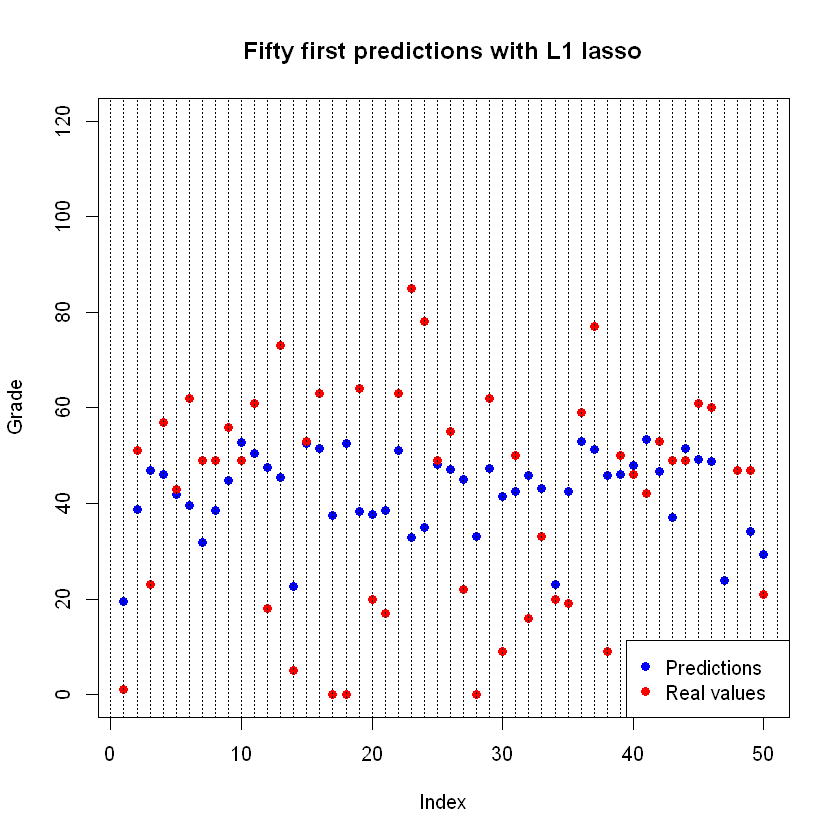

In [21]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions with L1 lasso')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

It appears (and this is confirmed as a tendency on all predictions) that the predictions are centered around 40 with very little variance compared to the real values.

(Regularization with lasso L2 was tried and was a bit worse in terms of MSE, without any other notable changes.)

## Other approach

It can also be interesting to evaluate the lasso MSE with lambda.1se: 

In [22]:
# lambda.1se -> lambda as large as possible while error is still 1 standard error from its minimum
best.lasso1.1se <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso1$lambda.1se)

In [23]:
paste('Number of non-zero predictors (lambda.1se): ', best.lasso1.1se$df)

y.pred.1se <- predict(cv.lasso1, test.x, s = 'lambda.1se')
lasso1.1se.MSE <- mean((y.pred.1se - test.y)^2)
paste('MSE = ', lasso1.1se.MSE)

[1] "Number of non-zero predictors (lambda.1se):  18"

[1] "MSE =  537.303246440954"

It gives us 5 important predictors. As expected, the MSE is higher than with lambda.min. 

In [24]:
best.lasso1.1se$beta

3028 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
Intensity               .           
complexity.from.pubmed  .           
MW                      .           
AMW                     .           
Sv                      .           
Se                      .           
Sp                      .           
Si                      .           
Mv                      .           
Me                      .           
Mp                      .           
Mi                      .           
nAT                     .           
nSK                     .           
nBT                     .           
nBO                     .           
nBM                     .           
SCBO                    .           
RBN                     .           
RBF                     .           
nDB                     .           
nTB                     .           
nAB                     .           
nH                      .           
nC                      .      

Linear fit with the 18 predictors found with lasso L1, lambda.1se.

As expected, the better we can do as a linear model is when using Lasso regularization.

# Subset Selection (cross-validation)

We considered finding a model with fewer predictors that approximate the data for a minimal MSE. Unfortunately, the data set is too linearly correlated to use the leaps library, in which case the alternative was lasso.